In [170]:
import os
import sys

In [171]:
sys.path.append('../lib')

In [172]:
import cov_independence_test
import hsic_independence_test
import gen_processes

In [173]:
from importlib import reload

In [302]:
reload(cov_independence_test);
reload(hsic_independence_test);
reload(gen_processes);

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar
import torch
torch.set_default_dtype(torch.double)
import sigkernel

In [121]:
import pprint
pp = pprint.PrettyPrinter(indent = 4)

In [122]:
import scipy.stats as stats

In [123]:
from tqdm import tqdm

In [124]:
from itertools import product

In [125]:
import matplotlib.pyplot as plt

In [126]:
rng = np.random.default_rng(1234)

In [127]:
BIG_RESULT_MEMORY_PLACE = []

In [333]:
N_TIMESTEPS = 1800
SIG_KERNEL_SAMPLES_NO = 60
M_RUNS = 50
#EXTINCTION_RATES = [0, 0.4, 0.5, 0.6, 0.7, 0.8]
EXTINCTION_RATES = [1]
PROC_DIV = 32
RBF_SIGMA = 2
A=0.2

In [ ]:
# TODO HOW A BOUT GBMS?

In [269]:
assert N_TIMESTEPS % SIG_KERNEL_SAMPLES_NO == 0, 'Cannot reshape such array properly'

In [270]:
processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(N_TIMESTEPS+1, M_RUNS, a = 0.2, extinction_rate = 1)

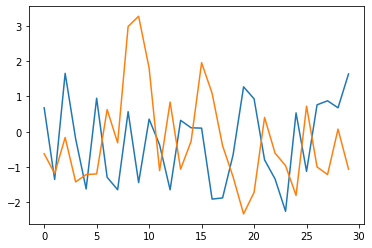

In [271]:
plt.plot(processes[rng.integers(0, M_RUNS), :30, 0])
plt.plot(processes[rng.integers(0, M_RUNS), :30, 1]);

In [272]:
def get_bootstrap_samples_lead_lag(X_raw, Y_raw):
    single_sample_length = int(N_TIMESTEPS / SIG_KERNEL_SAMPLES_NO)
        
    x_bootstrap_samples = torch.zeros(SIG_KERNEL_SAMPLES_NO, single_sample_length, 2)
    y_bootstrap_samples = torch.zeros(SIG_KERNEL_SAMPLES_NO, single_sample_length, 2)
    
    rng = np.random.default_rng(1234)
    
    for i in range(SIG_KERNEL_SAMPLES_NO):
        idx_low = rng.integers(0, N_TIMESTEPS - single_sample_length + 1)
        x_bootstrap_samples[i, :, 0] = X_raw[idx_low+1 : idx_low+single_sample_length+1]
        x_bootstrap_samples[i, :, 1] = X_raw[idx_low : idx_low+single_sample_length]
        y_bootstrap_samples[i, :, 0] = Y_raw[idx_low+1 : idx_low+single_sample_length+1]
        y_bootstrap_samples[i, :, 1] = Y_raw[idx_low : idx_low+single_sample_length]

    return x_bootstrap_samples, y_bootstrap_samples

In [332]:
for rate in EXTINCTION_RATES:#[0, 0.3, 0.8]:    
    hsic_results[rate] = []
    cov_results[rate] = []
    for run in range(5):
        processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(30, SIG_KERNEL_SAMPLES_NO, a=A, extinction_rate=rate)
        X_raw = processes[:, :, 0]
        X_lead_lag_chopped = torch.stack((X_raw[:, 1:], X_raw[:, :-1]), axis = 2)
        
        processes_p = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(30, SIG_KERNEL_SAMPLES_NO, a=A, extinction_rate=rate)
        Y_raw = processes_p[:, :, 0]
        Y_lead_lag_chopped = torch.stack((Y_raw[:, 1:], Y_raw[:, :-1]), axis = 2)
        
        #processes_p = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(30, SIG_KERNEL_SAMPLES_NO, a=0.8, extinction_rate=rate)
        #Y_raw = processes_p[:, :, 0]
        #Y_lead_lag_chopped = torch.stack((Y_raw[:, 1:], Y_raw[:, :-1]), axis = 2)

        #idy = torch.randperm(processes.shape[0])
        print(X_lead_lag_chopped.max())
        #sigkernel.hypothesis_test(processes/8, torch.stack((processes[:, :, 0], processes[idy, :, 1]), axis = 2)/8, static_kernel=  sigkernel.RBFKernel(sigma = 1))
        #sigkernel.hypothesis_test(X_lead_lag_chopped/4, Y_lead_lag_chopped/4, static_kernel = sigkernel.RBFKernel(sigma = 1), dyadic_order = 1)
        #sigkernel.hypothesis_test(X_lead_lag_chopped/8, Y_lead_lag_chopped/8, static_kernel = sigkernel.LinearKernel(), dyadic_order = 1)
        
        #hsic_test_result = hsic_independence_test.get_test_result_matrix_shuffle(X_lead_lag_chopped/PROC_DIV, Y_lead_lag_chopped/PROC_DIV, static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
        #hsic_test_result = hsic_independence_test.get_test_result_matrix_shuffle(X_lead_lag_chopped/PROC_DIV, Y_lead_lag_chopped/PROC_DIV, static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
        #cov_test_result = cov_independence_test.get_test_result(X, Y)
        print('RUN:', run)
        print('HSIC:', hsic_test_result[1:])
        #print('COV:', cov_test_result)

        hsic_results[rate].append(hsic_test_result)
        #cov_results[rate].append(cov_test_result)
        
    print('==================== END RATE {} ================='.format(rate))

tensor(4.1903)
Hypothesis accepted: distribution are equal with 99.0% confidence
RUN: 0
HSIC: (0.00029180898523484267, 0.84)
tensor(3.3684)
Hypothesis accepted: distribution are equal with 99.0% confidence
RUN: 1
HSIC: (0.00029180898523484267, 0.84)
tensor(3.7287)
Hypothesis accepted: distribution are equal with 99.0% confidence
RUN: 2
HSIC: (0.00029180898523484267, 0.84)
tensor(3.5722)
Hypothesis accepted: distribution are equal with 99.0% confidence
RUN: 3
HSIC: (0.00029180898523484267, 0.84)
tensor(3.1811)
Hypothesis accepted: distribution are equal with 99.0% confidence
RUN: 4
HSIC: (0.00029180898523484267, 0.84)
==================== END RATE 1 =================


In [334]:
hsic_results = {}
cov_results = {}

In [335]:
for rate in EXTINCTION_RATES:#[0, 0.3, 0.8]:    
    #processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(N_TIMESTEPS+1, M_RUNS, a=A, extinction_rate=rate)
    hsic_results[rate] = []
    cov_results[rate] = []
    for run in range(M_RUNS):
        #X_raw = processes[run, :, 0]
        #Y_raw = processes[run, :, 1]
        #X_lead_lag_chopped, Y_lead_lag_chopped = get_bootstrap_samples_lead_lag(X_raw, Y_raw)
        
        #X = X_raw[:N_TIMESTEPS]
        #Y = Y_raw[:N_TIMESTEPS]
        processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(30, SIG_KERNEL_SAMPLES_NO, a=A, extinction_rate=rate)
        X_raw = processes[:, :, 0]
        Y_raw = processes[:, :, 1]
        X_lead_lag_chopped = torch.stack((X_raw[:, 1:], X_raw[:, :-1]), axis = 2)
        Y_lead_lag_chopped = torch.stack((Y_raw[:, 1:], Y_raw[:, :-1]), axis = 2)
        #hsic_test_result = hsic_independence_test.get_test_result_matrix_shuffle(X_lead_lag_chopped/PROC_DIV, Y_lead_lag_chopped/PROC_DIV, static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
        hsic_test_result = hsic_independence_test.get_test_result_matrix_shuffle(X_lead_lag_chopped/PROC_DIV, Y_lead_lag_chopped/PROC_DIV, static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
        #cov_test_result = cov_independence_test.get_test_result(X, Y)
        print('RUN:', run)
        print('HSIC:', hsic_test_result[1:])
        #print('COV:', cov_test_result)

        hsic_results[rate].append(hsic_test_result)
        #cov_results[rate].append(cov_test_result)
        
    print('==================== END RATE {} ================='.format(rate))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.60it/s]


RUN: 0
HSIC: (6.855324012899899e-07, 0.5)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.66it/s]


RUN: 1
HSIC: (3.7029720156844803e-07, 0.76)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.94it/s]


RUN: 2
HSIC: (1.9039017908895062e-06, 0.02)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.86it/s]


RUN: 3
HSIC: (3.276664004570051e-07, 0.72)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.18it/s]


RUN: 4
HSIC: (5.667296147926493e-07, 0.5)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.19it/s]


RUN: 5
HSIC: (9.389716046914742e-07, 0.4)


KeyboardInterrupt: 

In [299]:
def get_null_rejection_rate(results):
    a = 0
    for tup in results:
        a += (tup[2] < 0.025) or (tup[2] > 0.975)
    return a / len(results)

In [279]:
def get_null_sampling_approx_from_all_results(all_results):
    null_approx = None
    for rate in all_results.keys():
        for tup in all_results[rate]:
            if null_approx == None:
                null_approx = tup[0]
            else:
                null_approx = torch.cat((null_approx, tup[0]), dim = 0)
    null =  np.array([item.item() for item in null_approx])
    null.sort()
    return null

In [280]:
def get_test_statistic_dists_from_all_results(all_results):
    hsic_dist = {}
    a = 0
    for rate in all_results.keys():
        hsic_dist[rate] = []
        for tup in all_results[rate]:
            hsic_dist[rate].append(tup[1])
        hsic_dist[rate] = np.array(hsic_dist[rate])
    return hsic_dist

In [281]:
def get_cov_null_rejection_rate(results):
    a = 0
    for tup in results:
        a += (tup[1] < 0.025) or (tup[1] > 0.975)
    return a / len(results)

In [282]:
def get_test_cutoff_thresholds_for_null(null):
    return (null[int((len(null)-1)*0.025)], null[int((len(null)-1)*0.975)])

In [283]:
null = get_null_sampling_approx_from_all_results(hsic_results)
test_statistic_dists = get_test_statistic_dists_from_all_results(hsic_results)
low_thresh, high_thresh = get_test_cutoff_thresholds_for_null(null)

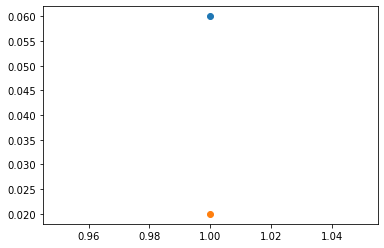

In [284]:
plt.scatter(EXTINCTION_RATES, [get_null_rejection_rate(hsic_results[rate]) for rate in EXTINCTION_RATES])
plt.scatter(EXTINCTION_RATES, [get_cov_null_rejection_rate(cov_results[rate]) for rate in EXTINCTION_RATES])

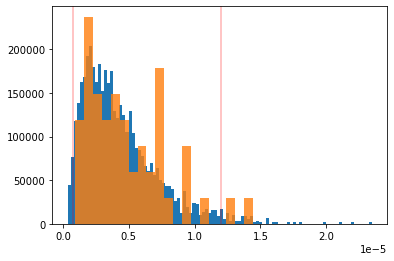

In [287]:
plt.hist(null, bins = 100, density = True);
plt.hist(test_statistic_dists[1], bins = 20, density = True, alpha = 0.8)
plt.axvline(low_thresh, alpha = 0.3, color = 'red')
plt.axvline(high_thresh, alpha = 0.3, color = 'red')

In [158]:
def push_results():
    BIG_RESULT_MEMORY_PLACE.append({
        'N_TIMESTEPS' : N_TIMESTEPS,
        'NO_TIMESTEPS_PER_SAMPLE' : int(N_TIMESTEPS / SIG_KERNEL_SAMPLES_NO),
        'SIG_KERNEL_SAMPLES_NO' : SIG_KERNEL_SAMPLES_NO,
        'M_RUNS' : M_RUNS,
        'COVS' : COVS,
        'COV RESULTS' : cov_results,
        'PROC_DIV' : PROC_DIV,
        'RBF_SIGMA' : RBF_SIGMA,
        'NULL' : null,
        'A' : A,
        'TEST DISTS' : test_statistic_dists,
        'TEST HIGH LOW THRES': (high_thresh, low_thresh),
        'COMMENT' : 'Using the V_statistic now, faster and also seems reliable'
    })
    pp.pprint(BIG_RESULT_MEMORY_PLACE[-1])

In [159]:
push_results()

{   'A': 0.2,
    'COMMENT': 'Using the V_statistic now, faster and also seems reliable',
    'COV RESULTS': {   0.8: [   (tensor(-0.0143), 0.6843193812019681),
                                (tensor(0.0237), 0.21211053013423442),
                                (tensor(0.0332), 0.13140236300723074),
                                (tensor(6.2296e-05), 0.4991988066445927),
                                (tensor(-0.0121), 0.6524937915668025),
                                (tensor(0.0111), 0.3556742167565139),
                                (tensor(0.0020), 0.47409369728552864),
                                (tensor(-0.0372), 0.893824006489681),
                                (tensor(-0.0205), 0.7432498589020573),
                                (tensor(0.0703), 0.008883144447755953),
                                (tensor(0.0005), 0.4934650016553316),
                                (tensor(-0.0083), 0.6066225784336718),
                                (tensor(-0.0283), 0.81959

In [160]:
import datetime

In [161]:
import pickle
with open('./hsic_test_on_extinct_gaussian_BIG_RESULTS_{}.pickle'.format(datetime.datetime.today()).replace(' ', '_').replace(':', '.'), 'wb') as f:
    pickle.dump(BIG_RESULT_MEMORY_PLACE, f)